# Explore Decoupled Intelligence

The proposal/hypothesis is here https://docs.google.com/document/d/1x7n2iy1_LZXZNLQpxCzF84lZ8BEG6ZT3KWXC59erhJA

This notebook investigates the **Structural Separation** hypothesis:
- Models contain distinct circuits for prompt categorization and response generation
- Categorization circuits are invariant to specific numeric inputs

Models like EleutherAI/gpt-j-6B need compute with a GPU e.g. in CoLab Pro with A100 GPU

In [7]:
# CatGen (singleton) config class
class CG:
    # Model we are testing. Runs on Colab Pro with ~16GB+ GPU (T4, V100, A100).
    MODEL_NAME = "EleutherAI/gpt-j-6B"

    # We assume model uses Layer 8 as the likely 'Categorization Layer'
    MODEL_LAYER = 8

    # Number of mathematical tasks we test
    NUM_TASKS = 6

    # We test each task using 5 pairs of numbers
    NUMBER_PAIRS = 5

    PROMPT_TEMPLATE = "Answer minimally: Given the numbers {x} and {y} calculate the {task}"

    IN_COLAB = False

## Step 1: Import Libraries

In [2]:
!pip install transformer-lens

In [3]:
import sys
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from transformers import GPTJForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA

In [8]:
try:
    import google.colab
    CG.IN_COLAB = True
except:
    CG.IN_COLAB = False

In [5]:
if CG.IN_COLAB:
    !pip install --upgrade git+https://github.com/PhilipQuirke/LlmPromptCategorization.git -q
else:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import MathsCatGen as mcg

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.9 MB/s eta 0:00:00


## Step 2: Load open-source model

In [9]:
# Takes 2 mins
model = HookedTransformer.from_pretrained(CG.MODEL_NAME, device="cuda" if torch.cuda.is_available() else "cpu")


config.json:   0%|          | 0.00/930 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin:   0%|          | 0.00/24.2G [00:00<?, ?B/s]

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

tokenizer_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Loaded pretrained model EleutherAI/gpt-j-6B into HookedTransformer


## Step 3: Define Tasks
We use the core math tasks that share identical phrasing up until the final task-identifying word .

In [10]:
tasks = mcg.get_maths_tasks()[0:CG.NUM_TASKS]
print(tasks)

['minimum', 'maximum', 'average', 'sum', 'difference', 'product']


In [11]:
test_data = mcg.generate_synthetic_matrix(CG.PROMPT_TEMPLATE, CG.NUMBER_PAIRS, CG.NUM_TASKS)
print(test_data)



Generated 5 total examples across 6 tasks
Examples per task: {95: 1, 45: 1, 29: 1, 2: 1, 87: 1}
    x   y                                             prompt  \
0  95  14  Answer minimally: Given the numbers 95 and 14 ...   
1  45  41  Answer minimally: Given the numbers 45 and 41 ...   
2  29  18  Answer minimally: Given the numbers 29 and 18 ...   
3   2   1  Answer minimally: Given the numbers 2 and 1 ca...   
4  87  95  Answer minimally: Given the numbers 87 and 95 ...   

                                  task_ground_truths  
0  [{'task': 'minimum', 'ground_truth': '14'}, {'...  
1  [{'task': 'minimum', 'ground_truth': '41'}, {'...  
2  [{'task': 'minimum', 'ground_truth': '18'}, {'...  
3  [{'task': 'minimum', 'ground_truth': '1'}, {'t...  
4  [{'task': 'minimum', 'ground_truth': '87'}, {'...  


In [12]:
# Generate the prompt list of CG.NUM_TASKS x CG.NUMBER_PAIRS examples
all_prompts = []
metadata = [] # To track task and pair for each prompt
for task in tasks:
    for i in range(CG.NUMBER_PAIRS):
        # Access x and y from the test_data DataFrame for the current pair index i
        x = test_data.loc[i, 'x']
        y = test_data.loc[i, 'y']

        # Use the global PROMPT_TEMPLATE to generate the full prompt, filling x, y, and task
        current_prompt = CG.PROMPT_TEMPLATE.format(x=x, y=y, task=task)

        # Grab the ground truth associated with the current task
        # 'task_ground_truths' column contains a list of dictionaries, not a dictionary directly indexable by 'task' string.
        # We need to find the dictionary within this list that matches the current 'task'.
        ground_truths_for_pair = test_data.loc[i, 'task_ground_truths']
        found_ground_truth_dict = next((item for item in ground_truths_for_pair if item["task"] == task), None)

        ground_truth_value = None
        if found_ground_truth_dict:
            ground_truth_value = found_ground_truth_dict.get('ground_truth')

        all_prompts.append(current_prompt)
        # Corrected the key "groundtruth:" to "groundtruth"
        metadata.append({"task": task, "pair": f"({x},{y})", "groundtruth": ground_truth_value})

print(all_prompts[0:5])
print(metadata[0:5])


['Answer minimally: Given the numbers 95 and 14 calculate the minimum', 'Answer minimally: Given the numbers 45 and 41 calculate the minimum', 'Answer minimally: Given the numbers 29 and 18 calculate the minimum', 'Answer minimally: Given the numbers 2 and 1 calculate the minimum', 'Answer minimally: Given the numbers 87 and 95 calculate the minimum']
[{'task': 'minimum', 'pair': '(95,14)', 'groundtruth': '14'}, {'task': 'minimum', 'pair': '(45,41)', 'groundtruth': '41'}, {'task': 'minimum', 'pair': '(29,18)', 'groundtruth': '18'}, {'task': 'minimum', 'pair': '(2,1)', 'groundtruth': '1'}, {'task': 'minimum', 'pair': '(87,95)', 'groundtruth': '87'}]


## Step 4: Extract Residual Stream Activations
To isolate the "Categorization Layer", you should extract the activations from the residual stream at the final token position across all layers. The final token (the task word) is where the categorization is finalized.

In [13]:
model_prompt_act = []
model_answers = []

for prompt in all_prompts:
    with torch.no_grad():
        # Extract activations for the categorization layer analysis using run_with_cache
        logits_for_activations, cache = model.run_with_cache(prompt)
        vec = cache["resid_post", CG.MODEL_LAYER][0, -1, :].detach().cpu()
        model_prompt_act.append(vec)

        # Generate a sequence of tokens for the model's answer
        input_ids = model.tokenizer.encode(prompt, return_tensors='pt').to(model.cfg.device)
        # Generate up to 10 new tokens for the answer. Using do_sample=False for deterministic output.
        generated_output_ids = model.generate(
            input_ids,
            max_new_tokens=10, # Allow up to 10 new tokens to cover ~35 characters
            do_sample=False,   # For deterministic answers for mathematical tasks
            temperature=0.0    # Set temperature to 0.0 for greedy decoding
            # Removed pad_token_id as it's not accepted by HookedTransformer.generate() for this model
        )

        # Decode only the newly generated part of the output
        generated_answer_tokens = generated_output_ids[0, len(input_ids[0]):]
        predicted_answer = model.tokenizer.decode(generated_answer_tokens, skip_special_tokens=True).strip()
        model_answers.append(predicted_answer)

model_prompt_tensor = torch.stack(model_prompt_act)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
print(model_answers[0:5])

['number of times you need to add 1 to 95', 'number of times the sum of the two numbers is', 'number of times you need to add 29 to 18', 'number of times you need to multiply 2 by 1', 'number of times you need to add 1 to the']


## Step 5: Disentangling Categorization from Data

We subtract the average prompt "template" to find the task-specific vectors

In [15]:
# Calculate global mean (centroid) to remove template bias
global_centroid = model_prompt_tensor.mean(dim=0)
task_specific_vectors = model_prompt_tensor - global_centroid

## Step 6: Visualization: Similarity Heatmap

A powerful way to visualize this disentanglement is to create a similarity heatmap of all prompts (NUM_TASKS × NUMBER_PAIRS):
- You should see NUM_TASKS distinct "blocks" along the diagonal.
- Each block represents a task (e.g., all "sum" prompts).
- High similarity in a block = Stability across the pairs of numbers
- Low similarity between blocks = Different activations for different tasks => clear categorization between tasks.

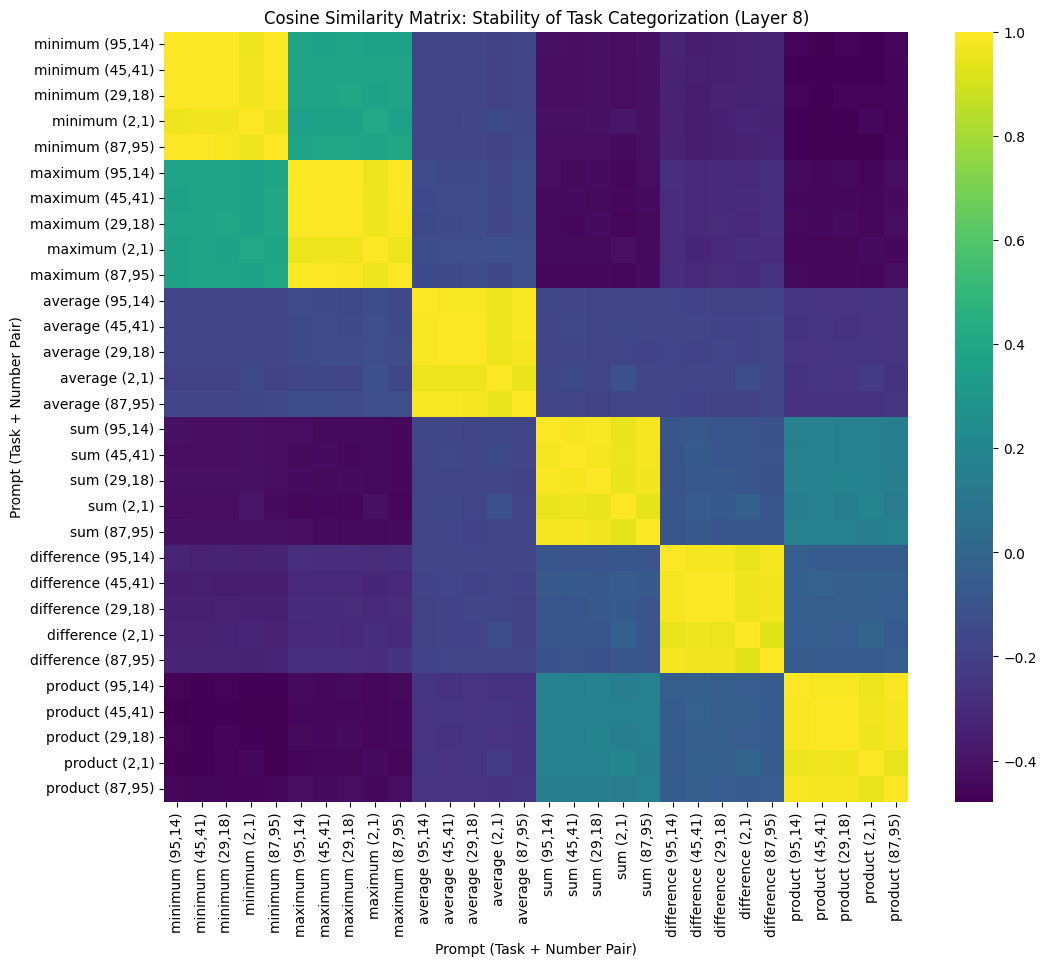

In [16]:
# Normalize for cosine similarity
norm_vecs = F.normalize(task_specific_vectors, p=2, dim=1)
sim_matrix = torch.mm(norm_vecs, norm_vecs.t()).numpy()

plt.figure(figsize=(12, 10))
labels = [f"{m['task']} {m['pair']}" for m in metadata]
sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap="viridis", annot=False)
plt.title(f"Cosine Similarity Matrix: Stability of Task Categorization (Layer {CG.MODEL_LAYER})")
plt.xlabel("Prompt (Task + Number Pair)")
plt.ylabel("Prompt (Task + Number Pair)")
plt.show()

## Step 7. Visualization: PCA Projection

We project the NUM_TASKS × NUMBER_PAIRS vectors into 2D space to see the "Task Clusters"

If the "Structural Separation" hypothesis is true, these task clusters should be geometrically distant in the PCA plot. This is useful but weak evidence.

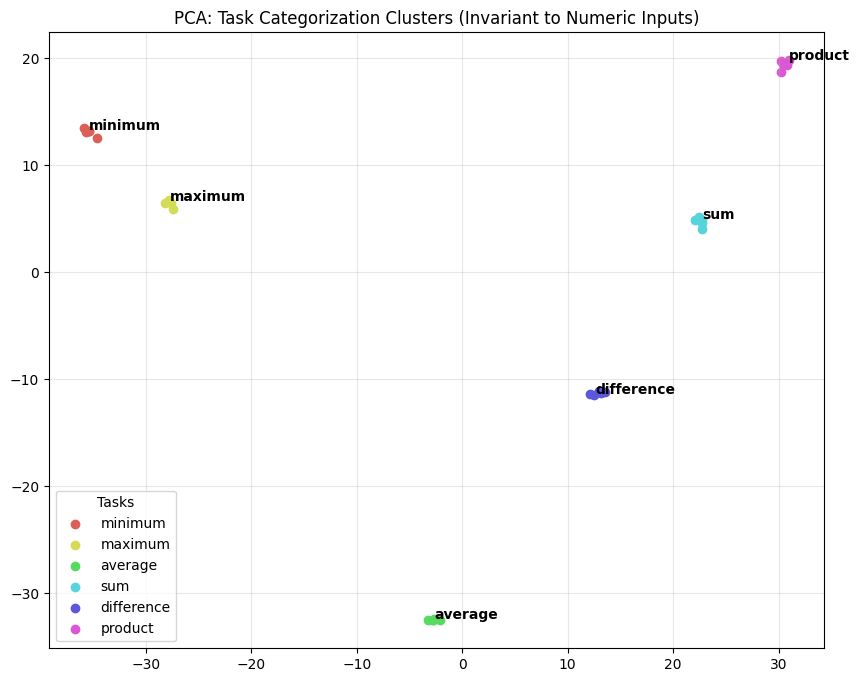

In [17]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(task_specific_vectors.numpy())

plt.figure(figsize=(10, 8))
colors = sns.color_palette("hls", len(tasks))
task_colors = {task: colors[i] for i, task in enumerate(tasks)}

for i, meta in enumerate(metadata):
    plt.scatter(
        pca_results[i, 0],
        pca_results[i, 1],
        color=task_colors[meta['task']],
        label=meta['task'] if i % 5 == 0 else ""
    )
    # Label a few points
    if i % 5 == 0:
        plt.text(pca_results[i, 0] + 0.05, pca_results[i, 1] + 0.05, meta['task'], weight='bold')

plt.legend(title="Tasks")
plt.title("PCA: Task Categorization Clusters (Invariant to Numeric Inputs)")
plt.grid(True, alpha=0.3)
plt.show()

## What these results show

- Intra-Task Consistency: The 5x5 blocks on the heatmap diagonal show how similar "sum (25,9)" is to "sum (99,1)". High similarity here confirms the categorization circuit is ignoring numeric noise.

- Inter-Task Orthogonality: The dark regions between blocks represent the separation between tasks. If the "Structural Separation" hypothesis is true, these task clusters should be geometrically distant in the PCA plot.

- Scale Coordination: You can observe if the clusters are roughly the same distance from the center, which would support the idea that the model uses a unified activation scale for all 100 tasks